In [1]:
from altaipony.lcio import from_mast, from_path
from altaipony.injrecanalysis import plot_heatmap, tile_up_injection_recovery
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve

import pytest
import numpy as np




import matplotlib.pyplot as plt
%matplotlib inline

from funcs.helper import write_flares_to_file, read_custom_aperture_lc, get_window_length_dict
from funcs.custom_detrending import custom_detrending, search_gaps_for_window_length, refine_detrended_flux_err

import copy


from scipy.interpolate import UnivariateSpline

import os

CWD = "/".join(os.getcwd().split("/")[:-2])

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib64/python3.6/site-packages/_pytest/mark/structures.py:370: DeprecationWarning: The usage of `cmp` is deprecated and will be removed on or after 2021-06-01.  Please use `eq` and `order` instead.
  @attr.s(cmp=False, hash=False)


In [2]:
clcs = ! ls ../custom_aperture/*fits
clcs = [x.split("/")[-1] for x in clcs]

def get_customlc(TIC, c, clcs):
    for p in clcs:
        if (str(TIC) in p.split("-")[2]) & (c == int(p.split("-")[1][1:])):
            print(p)
            pac = p
    return pac


In [3]:
clcs

['0ca_tess2019082014090-s0001-0000000029780677-0000-s_lc.fits',
 '100ca_tess2019090910225-s0007-0000000318801864-0000-s_lc.fits',
 '101ca_tess2019090910464-s0007-0000000366567664-0000-s_lc.fits',
 '102ca_tess2019090910530-s0007-0000000410898932-0000-s_lc.fits',
 '103ca_tess2019090910582-s0008-0000000000926898-0000-s_lc.fits',
 '103ca_tess2019102415201-s0008-0000000000926898-0000-s_lc.fits',
 '104ca_tess2019090911104-s0008-0000000007975441-0000-s_lc.fits',
 '105ca_tess2019090911241-s0008-0000000011654435-0000-s_lc.fits',
 '106ca_tess2019090911283-s0008-0000000044984200-0000-s_lc.fits',
 '107ca_tess2019100910514-s0008-0000000130414729-0000-s_lc.fits',
 '108ca_tess2019090911533-s0008-0000000142052876-0000-s_lc.fits',
 '108ca_tess2019102509445-s0008-0000000142052876-0000-s_lc.fits',
 '109ca_tess2019090911560-s0008-0000000167894019-0000-s_lc.fits',
 '109ca_tess2019102510083-s0008-0000000167894019-0000-s_lc.fits',
 '10ca_tess2019100710504-s0001-0000000401984769-0000-s_lc.fits',
 '110ca_tess2

In [5]:
paths = ! ls ../injrec/
print(paths)
ids = [p.split("_")[0]for p in paths]
cs = [p.split("_")[1][1:-4]for p in paths]
targs = list(zip(ids,cs))
targs = list(set(targs))
len(targs)

['000007150628_s0002.csv', '000029780677_s0001.csv', '000029780677_s0002.csv', '000029780677_s0003.csv', '000029928567_s0003.csv', '000034014829_s0002.csv', '000038314290_s0003.csv', '000070555405_s0003.csv', '000077041175_s0002.csv', '000142052876_s0001.csv', '000142052876_s0002.csv', '000167894019_s0001.csv', '000167894019_s0002.csv', '000180724005_s0002.csv', '000220429097_s0001.csv', '000220429097_s0002.csv', '000234307350_s0001.csv', '000234307350_s0002.csv', '000259901346_s0001.csv', '000259901346_s0002.csv', '000270218775_s0002.csv', '000280801342_s0001.csv', '000281668854_s0002.csv', '000303978478_s0001.csv', '000303978478_s0002.csv', '000304392811_s0002.csv', '000340703996_s0002.csv', '000358108509_s0001.csv', '000358108509_s0002.csv', '000369863567_s0013.csv', '000389051009_s0001.csv', '000401984769_s0001.csv', '000401984769_s0002.csv']


33

In [6]:
targs



[('000304392811', '0002'),
 ('000220429097', '0001'),
 ('000167894019', '0002'),
 ('000029780677', '0003'),
 ('000167894019', '0001'),
 ('000234307350', '0002'),
 ('000220429097', '0002'),
 ('000340703996', '0002'),
 ('000034014829', '0002'),
 ('000038314290', '0003'),
 ('000029780677', '0002'),
 ('000077041175', '0002'),
 ('000142052876', '0002'),
 ('000142052876', '0001'),
 ('000259901346', '0001'),
 ('000029780677', '0001'),
 ('000303978478', '0002'),
 ('000389051009', '0001'),
 ('000070555405', '0003'),
 ('000358108509', '0002'),
 ('000234307350', '0001'),
 ('000029928567', '0003'),
 ('000401984769', '0002'),
 ('000401984769', '0001'),
 ('000180724005', '0002'),
 ('000358108509', '0001'),
 ('000303978478', '0001'),
 ('000259901346', '0002'),
 ('000280801342', '0001'),
 ('000007150628', '0002'),
 ('000281668854', '0002'),
 ('000270218775', '0002'),
 ('000369863567', '0013')]

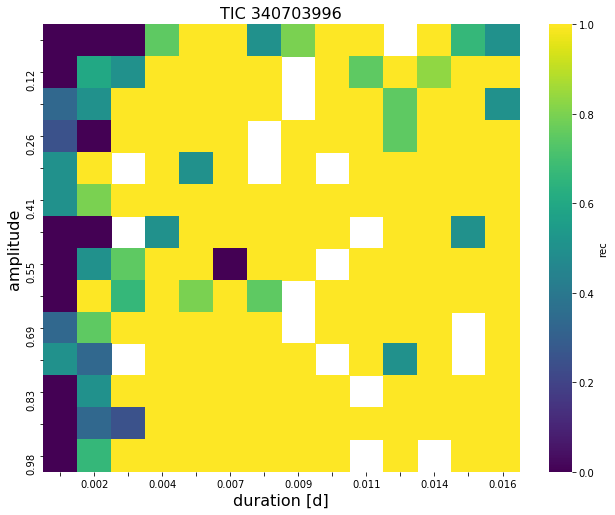

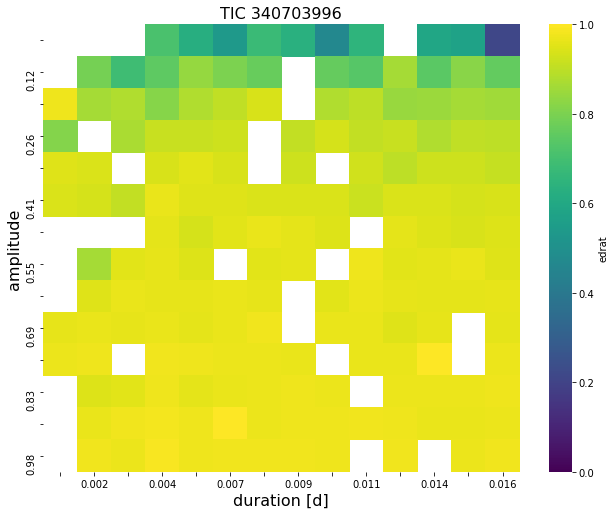

In [91]:
bins = 14
dff, val = tile_up_injection_recovery(df, "recovery_probability",ampl_bins=bins, dur_bins=bins,)
plot_heatmap(dff, val, ID=TIC);
dff, val = tile_up_injection_recovery(df, "ed_ratio",ampl_bins=bins, dur_bins=bins,)
plot_heatmap(dff, val, ID=TIC);

In [80]:
TIC = int(TIC)
c = int(c)

In [81]:
pac = get_customlc(TIC, c, clcs)
print(pac)
pac = "/work1/eilin/TESS_UCDs/TESS_UCD_flares/custom_aperture/" + pac

25ca_tess2019090412554-s0002-0000000340703996-0000-s_lc.fits
25ca_tess2019090412562-s0002-0000000340703996-0000-s_lc.fits
25ca_tess2019090412562-s0002-0000000340703996-0000-s_lc.fits


In [82]:
#------ Find flares -------------------------------------------------------------

#d = get_window_length_dict()

flc = read_custom_aperture_lc(pac)


flcd = flc.detrend("custom", func=custom_detrending)

flcd = flcd.find_flares()

#--------------------------------------------------------------------------------

print("\nFinished TIC {} ({})\n------------------------------\n".format(TIC, flc.campaign))

/work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib64/python3.6/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.FileIO name='/work1/eilin/TESS_UCDs/TESS_UCD_flares/custom_aperture/25ca_tess2019090412562-s0002-0000000340703996-0000-s_lc.fits' mode='rb' closefd=True>
  """
Found 3 candidate(s) in the (0,9077) gap.
Found 1 candidate(s) in the (9077,18018) gap.



Finished TIC 340703996 (2)
------------------------------



In [83]:
flcd.flares

,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop
0,0.029880,94166,94173,15.166048,0.644338,2786,2793,18018.0,1358.246442,1358.256165
1,0.507924,97099,97113,128.766170,0.572362,5658,5672,18018.0,1362.320152,1362.339597
2,0.078210,100436,100439,16.777055,0.598524,8930,8933,18018.0,1366.954965,1366.959132
3,0.140141,105530,105535,24.486479,0.351771,12920,12925,18018.0,1374.030041,1374.036986


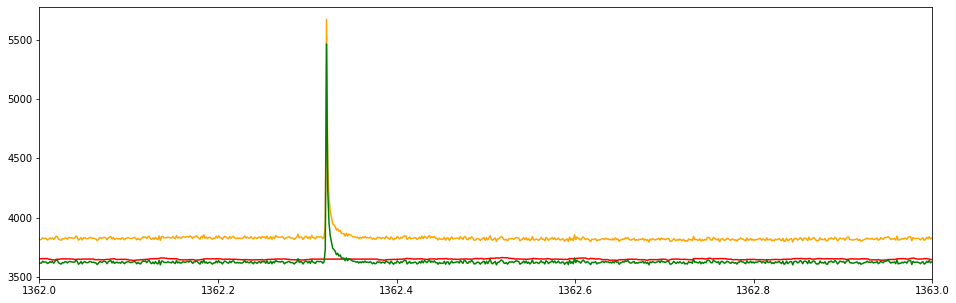

In [87]:
plt.figure(figsize=(16,5))
f = 5

plt.plot(flc.time, flc.flux+f*40, c="orange");
plt.plot(flcd.time, flcd.it_med+3*flcd.detrended_flux_err, c="r");
plt.plot(flcd.time, flcd.detrended_flux, c="g");
plt.xlim(1362,1363);
#plt.ylim(1400,2250)

In [89]:
flcd.fake_flares = df
flcd = flcd.characterize_flares(ampl_bins=bins, dur_bins=bins)

In [90]:
flcd.flares.sort_values(by="ampl_rec").head().T

,0,2,3,1
ampl_rec,0.0298798,0.0782101,0.140141,0.507924
cstart,94166,100436,105530,97099
cstop,94173,100439,105535,97113
ed_rec,15.166,16.7771,24.4865,128.766
ed_rec_err,0.644338,0.598524,0.351771,0.572362
istart,2786,8930,12920,5658
istop,2793,8933,12925,5672
total_n_valid_data_points,18018,18018,18018,18018
tstart,1358.25,1366.95,1374.03,1362.32
tstop,1358.26,1366.96,1374.04,1362.34


In [ ]:
with open("/work1/eilin/TESS_UCDs/TESS_UCD_flares/flare_tables/20200217_vetted_flares.csv", "a") as f:
    flcd.flares.to_csv(f, index=False, header=False)